In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import sys
from iminuit import Minuit
from matplotlib.colors import ListedColormap
from tqdm import tqdm
import scipy.stats as stats
import os
import nestle
from sklearn.neighbors import KernelDensity

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.inspection import permutation_importance

# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

In [4]:
sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH, simpson38
from ExternalFunctions import nice_string_output, add_text_to_ax 

In [5]:
COLOUR = ['#1E90FF', # 0 # Dodgerblue
          '#FFBF00', # 1 # Amber
          '#FF6347', # 2 # Tomato
          '#00A86B', # 3 # Jade
          '#8A2BE2', # 4 # Blueviolet
          '#FF6FFF', # 5 # Ultra Pink
          '#00CCFF', # 6 # Vivid Sky Blue
          '#00ff40', # 7 # Erin
          '#FF004F', # 8 # Folly
          '#0063A6', # 9 # Lapis Lazuli
        ]
def setMplParam(classNum):
    # Define effective colors, line styles, and markers based on the class number
   
    LINE = ['-', '-.', '--', '-.', ':','--','-.','-', ':', '--']
    MARKER = ['.','*', '^', 's', '.', 'p', 'o', 's', '.', 'd']
    COLOUR_EFF = COLOUR[:classNum]
    LINE_EFF = LINE[:classNum]
    MARKER_EFF = MARKER[:classNum]

    # Set the color cycle for lines including color, line style, and marker
    plt.rcParams['axes.prop_cycle'] = (plt.cycler(color=COLOUR_EFF) +
                                       plt.cycler(linestyle=LINE_EFF)+
                                       plt.cycler(marker=MARKER_EFF))

    # Set default line and marker sizes
    plt.rcParams['lines.markersize'] = 3  # Example size
    plt.rcParams['lines.linewidth'] = 2   # Example width for lines

    # Set label and title sizes
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['axes.titlesize'] = 20

    # Set tick properties
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['ytick.labelsize'] = 20

    # Set legend font size
    plt.rcParams['legend.fontsize'] = 12

    # Enable and configure grid
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.8
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.linewidth'] = 1

    # Set axes line width
    plt.rcParams['axes.linewidth'] = 2

    # Set tick sizes and widths
    plt.rcParams['xtick.major.size'] = 7
    plt.rcParams['xtick.major.width'] = 3
    plt.rcParams['xtick.minor.size'] = 2
    plt.rcParams['xtick.minor.width'] = 2

    plt.rcParams['ytick.major.size'] = 7
    plt.rcParams['ytick.major.width'] = 3
    plt.rcParams['ytick.minor.size'] = 2
    plt.rcParams['ytick.minor.width'] = 2

setMplParam(10)


In [6]:
def generateVariables():
    N = 1000
    t1 = np.random.uniform(0, 7*np.pi, N)
    t2 = np.random.uniform(0, 7*np.pi, N)
    t3 = np.random.uniform(0,3, N)
    return t1, t2, t3

In [7]:
def scaledPrior(u):
    return np.array([7 * np.pi * u[0], 7 * np.pi * u[1], 3 * u[2]])

In [8]:
def L(t):
    t1, t2, t3 = t
    mu = 0.68
    sigma = np.sqrt(0.04)
    term_1 = np.cos(t1)*np.cos(t2)
    term_2 = 1 / sigma / np.sqrt(2 * np.pi) * np.exp(-0.5 * (t3 - mu)**2 / sigma**2) * np.cos(t1/2)
    term_3 = 3
    return 3 * (term_1 + term_2 + term_3)

In [9]:
def MultiNest():
    np.random.seed(99)
    return nestle.sample(L, scaledPrior, 3)
result = MultiNest()

Best-fit values of θ1, θ2, and θ3: [12.65828546  6.28819524  0.67232527]


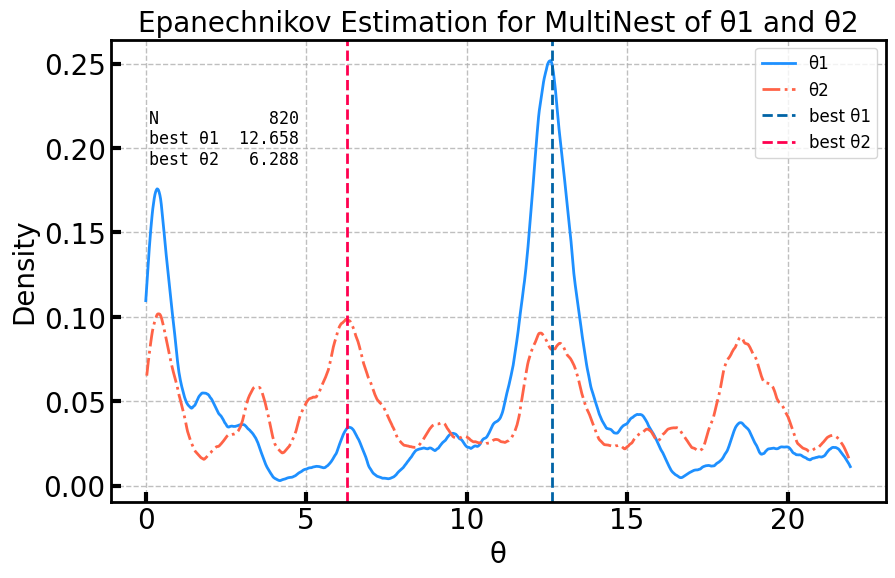

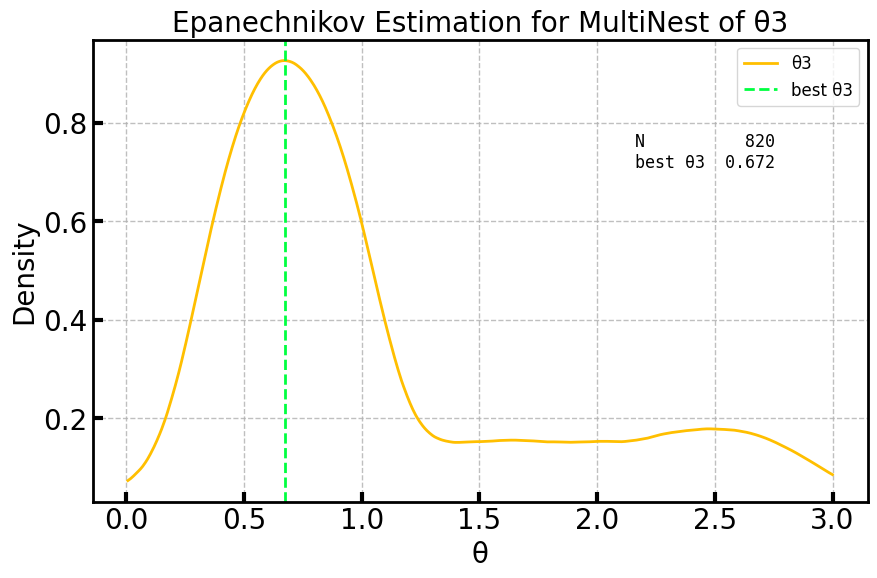

In [10]:
def plotVariables(result):
    
    bestVariables = result.samples[np.argmax(result.logl)]
    t1_best = bestVariables[0]
    t2_best = bestVariables[1]
    t3_best = bestVariables[2]

    def EpanechnikovKDE(samples, color, label, ax):
        kde = KernelDensity(kernel='epanechnikov', bandwidth=0.5).fit(samples[:, None])
        x_d = np.linspace(min(samples), max(samples), 1000)[:, None]
        log_dens = kde.score_samples(x_d)
        ax.plot(x_d[:, 0], np.exp(log_dens), label=label, color=color, marker = '')

    fig_1, ax_1 = plt.subplots(figsize=(10, 6))
    EpanechnikovKDE(result.samples[:, 0], COLOUR[0], 'θ1', ax_1)
    EpanechnikovKDE(result.samples[:, 1], COLOUR[2], 'θ2', ax_1)
    ax_1.axvline(t1_best, color=COLOUR[9], linestyle='--', label='best θ1', marker = '')
    ax_1.axvline(t2_best, color=COLOUR[8], linestyle='--', label='best θ2', marker = '')
    ax_1.set_title('Epanechnikov Estimation for MultiNest of θ1 and θ2')
    ax_1.set_xlabel('θ')
    ax_1.set_ylabel('Density')
    ax_1.legend()

    fig_3, ax_3 = plt.subplots(figsize=(10, 6))
    EpanechnikovKDE(result.samples[:, 2], COLOUR[1], 'θ3', ax_3)
    ax_3.axvline(t3_best, color=COLOUR[7], linestyle='--', label='best θ3', marker = '')
    ax_3.set_title('Epanechnikov Estimation for MultiNest of θ3')
    ax_3.set_xlabel('θ')
    ax_3.set_ylabel('Density')
    ax_3.legend()

    d_1 = {
        'N' : len(result.samples[:, 0]),
        'best θ1' : t1_best,
        'best θ2' : t2_best,
        }
    text_1 = nice_string_output(d_1, extra_spacing=2, decimals=3)
    add_text_to_ax(0.05, 0.85, text_1, ax_1, fontsize=12)

    d_3 = {
        'N' : len(result.samples[:, 2]),
        'best θ3' : t3_best,
        }
    text_3 = nice_string_output(d_3, extra_spacing=2, decimals=3)
    add_text_to_ax(0.7, 0.80, text_3, ax_3, fontsize=12)

    print("Best-fit values of θ1, θ2, and θ3:", bestVariables)
plotVariables(result)


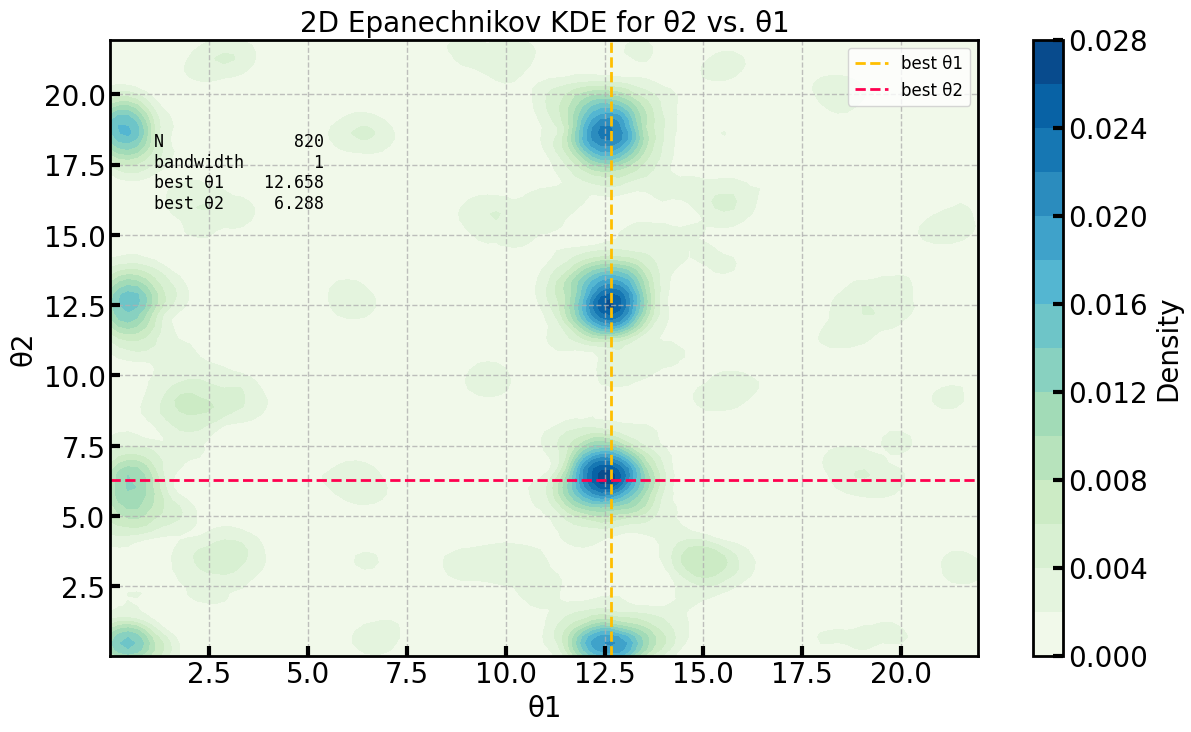

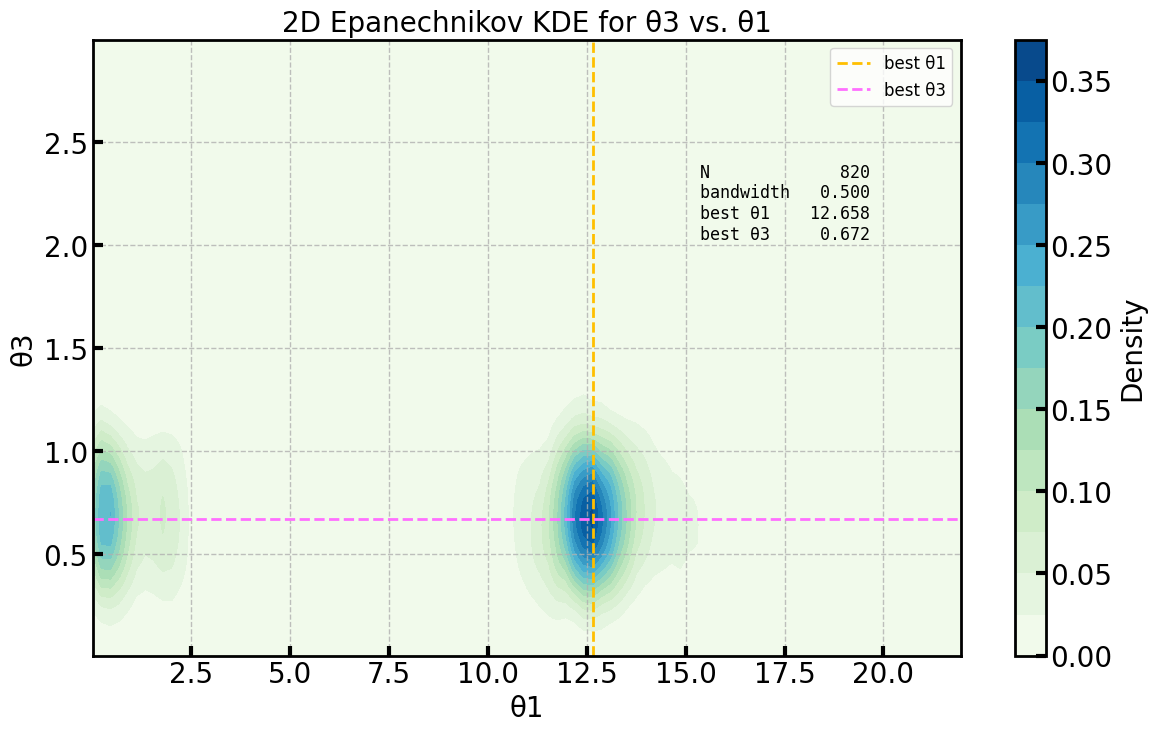

In [11]:
def plot2Ddistribution(result):
    t1_samples = result.samples[:, 0]
    t2_samples = result.samples[:, 1]
    t3_samples = result.samples[:, 2]

    t1_min, t1_max = t1_samples.min(), t1_samples.max()
    t2_min, t2_max = t2_samples.min(), t2_samples.max()
    t3_min, t3_max = t3_samples.min(), t3_samples.max()

    bestVariables = result.samples[np.argmax(result.logl)]
    t1_best = bestVariables[0]
    t2_best = bestVariables[1]
    t3_best = bestVariables[2]
    
    #  t2 vs t1
    t1_grid, t2_grid = np.mgrid[t1_min:t1_max:100j, t2_min:t2_max:100j]
    grid_samples = np.vstack([t1_grid.ravel(), t2_grid.ravel()]).T
    bw1 = 1
    kde = KernelDensity(kernel='epanechnikov', bandwidth=bw1).fit(np.vstack([t1_samples, t2_samples]).T)
    log_density = kde.score_samples(grid_samples).reshape(100, 100)
    
    # t3 vs t1
    t1_grid_3, t3_grid = np.mgrid[t1_min:t1_max:100j, t3_min:t3_max:100j]
    grid_samples_3 = np.vstack([t1_grid_3.ravel(), t3_grid.ravel()]).T
    bw3 = 0.5
    kde_3 = KernelDensity(kernel='epanechnikov', bandwidth=bw3).fit(np.vstack([t1_samples, t3_samples]).T)
    log_density_3 = kde_3.score_samples(grid_samples_3).reshape(100, 100)

    fig_1, ax_1 = plt.subplots(figsize=(14, 8))
    cf1 = ax_1.contourf(t1_grid, t2_grid, np.exp(log_density), levels=15, cmap="GnBu")
    ax_1.axvline(t1_best, color=COLOUR[1], linestyle='--', label='best θ1', marker = '')
    ax_1.axhline(t2_best, color=COLOUR[8], linestyle='--', label='best θ2', marker = '')
    ax_1.set_xlabel('θ1')
    ax_1.set_ylabel('θ2')
    ax_1.set_title('2D Epanechnikov KDE for θ2 vs. θ1')
    ax_1.legend()
    fig_1.colorbar(cf1, ax=ax_1, label='Density')
    
    fig_3, ax_3 = plt.subplots(figsize=(14, 8))
    cf3 = ax_3.contourf(t1_grid_3, t3_grid, np.exp(log_density_3), levels=15, cmap="GnBu")
    ax_3.axvline(t1_best, color=COLOUR[1], linestyle='--', label='best θ1', marker = '')
    ax_3.axhline(t3_best, color=COLOUR[5], linestyle='--', label='best θ3', marker = '')
    ax_3.set_xlabel('θ1')
    ax_3.set_ylabel('θ3')
    ax_3.set_title('2D Epanechnikov KDE for θ3 vs. θ1')
    ax_3.legend()
    fig_3.colorbar(cf3, ax=ax_3, label='Density')

    d_1 = {
        'N' : len(result.samples[:, 0]),
        'bandwidth' : bw1,
        'best θ1' : t1_best,
        'best θ2' : t2_best,
        }
    text_1 = nice_string_output(d_1, extra_spacing=2, decimals=3)
    add_text_to_ax(0.05, 0.85, text_1, ax_1, fontsize=12)

    d_3 = {
        'N' : len(result.samples[:, 2]),
        'bandwidth' : bw3,
        'best θ1' : t1_best,
        'best θ3' : t3_best,
        }
    text_3 = nice_string_output(d_3, extra_spacing=2, decimals=3)
    add_text_to_ax(0.7, 0.80, text_3, ax_3, fontsize=12)

plot2Ddistribution(result)


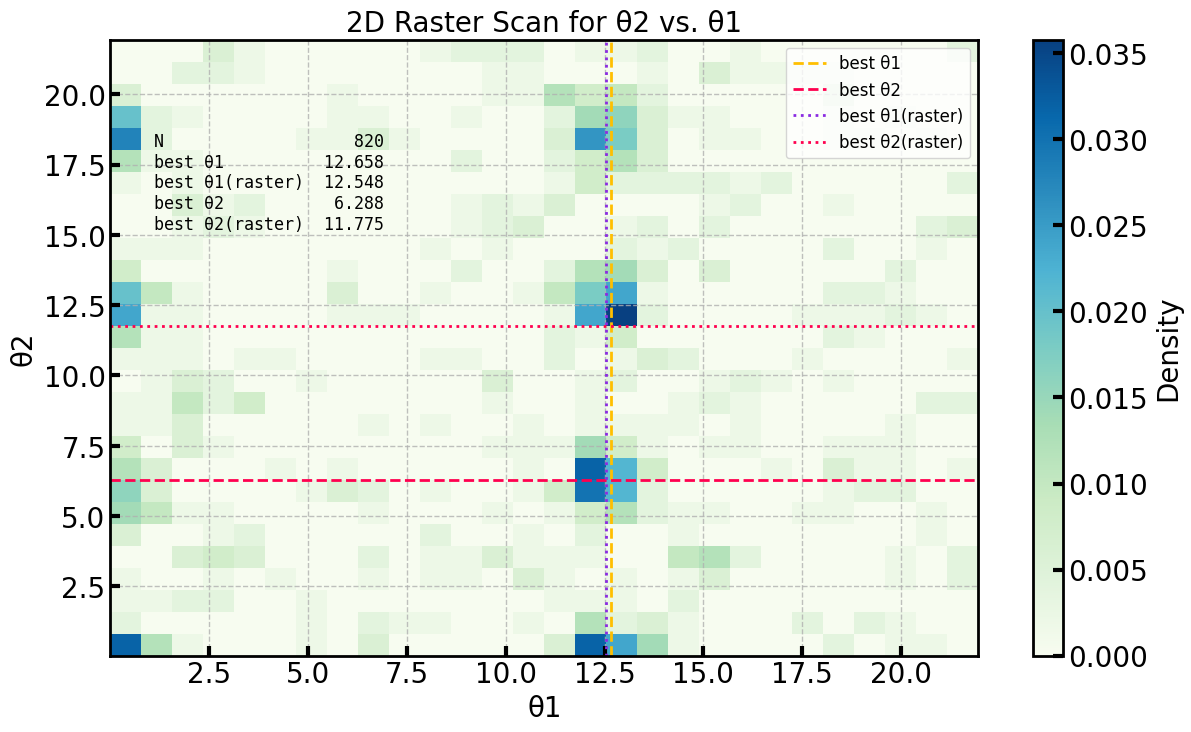

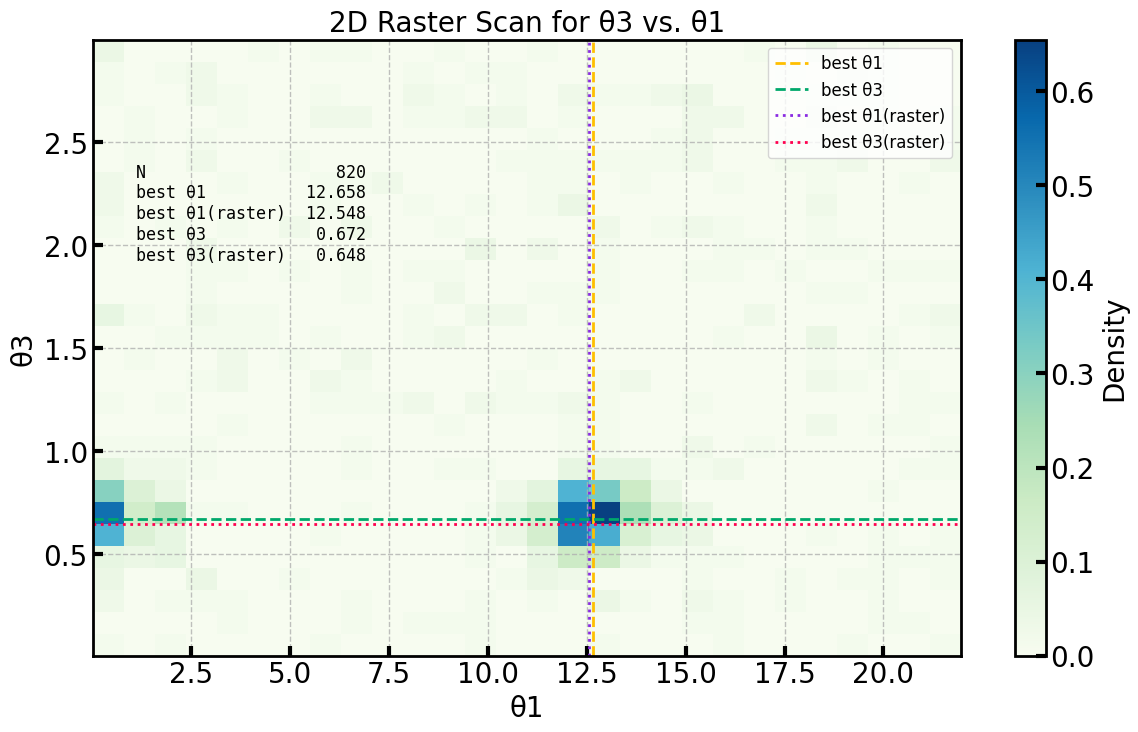

In [13]:
def plot2Draster(result):
    t1_samples = result.samples[:, 0]
    t2_samples = result.samples[:, 1]
    t3_samples = result.samples[:, 2]

    Nbins = int(np.sqrt(len(t1_samples)))

    bestVariables = result.samples[np.argmax(result.logl)]
    t1_best = bestVariables[0]
    t2_best = bestVariables[1]
    t3_best = bestVariables[2]
    
    fig_1, ax_1 = plt.subplots(figsize=(14, 8))
    h2d_1 = ax_1.hist2d(t1_samples, t2_samples, bins=Nbins, cmap="GnBu", density=True)
    ax_1.axvline(t1_best, color=COLOUR[1], linestyle='--', label='best θ1')
    ax_1.axhline(t2_best, color=COLOUR[8], linestyle='--', label='best θ2')
    
    max_density_idx_1 = np.argmax(h2d_1[0])
    max_bin_x_1, max_bin_y_1 = np.unravel_index(max_density_idx_1, h2d_1[0].shape)
    ax_1.axvline(x=h2d_1[1][max_bin_x_1], color=COLOUR[4], linestyle=':', label='best θ1(raster)')
    ax_1.axhline(y=h2d_1[2][max_bin_y_1], color=COLOUR[8], linestyle=':', label='best θ2(raster)')
    ax_1.set_xlabel('θ1')
    ax_1.set_ylabel('θ2')
    ax_1.set_title('2D Raster Scan for θ2 vs. θ1')
    ax_1.legend()
    fig_1.colorbar(h2d_1[3], ax=ax_1, label='Density')
    
    fig_3, ax_3 = plt.subplots(figsize=(14, 8))
    h2d_3 = ax_3.hist2d(t1_samples, t3_samples, bins=Nbins, cmap="GnBu", density=True)
    ax_3.axvline(t1_best, color=COLOUR[1], linestyle='--', label='best θ1')
    ax_3.axhline(t3_best, color=COLOUR[3], linestyle='--', label='best θ3')

    max_density_idx_3 = np.argmax(h2d_3[0])
    max_bin_x_3, max_bin_y_3 = np.unravel_index(max_density_idx_3, h2d_3[0].shape)
    ax_3.axvline(x=h2d_3[1][max_bin_x_3], color=COLOUR[4], linestyle=':', label='best θ1(raster)')
    ax_3.axhline(y=h2d_3[2][max_bin_y_3], color=COLOUR[8], linestyle=':', label='best θ3(raster)')
    ax_3.set_xlabel('θ1')
    ax_3.set_ylabel('θ3')
    ax_3.set_title('2D Raster Scan for θ3 vs. θ1')
    ax_3.legend()
    fig_3.colorbar(h2d_3[3], ax=ax_3, label='Density')

    d_1 = {
        'N' : len(result.samples[:, 0]),
        'best θ1' : t1_best,
        'best θ1(raster)' : h2d_1[1][max_bin_x_1],
        'best θ2' : t2_best,
        'best θ2(raster)' : h2d_1[2][max_bin_y_1],
        }
    text_1 = nice_string_output(d_1, extra_spacing=2, decimals=3)
    add_text_to_ax(0.05, 0.85, text_1, ax_1, fontsize=12)

    d_3 = {
        'N' : len(result.samples[:, 2]),
        'best θ1' : t1_best,
        'best θ1(raster)' : h2d_3[1][max_bin_x_3],
        'best θ3' : t3_best,
        'best θ3(raster)' : h2d_3[2][max_bin_y_3],
        }
    text_3 = nice_string_output(d_3, extra_spacing=2, decimals=3)
    add_text_to_ax(0.05, 0.80, text_3, ax_3, fontsize=12)
    
plot2Draster(result)
